In [1]:
#Importing necessary packages
import numpy as np 
import pandas as pd 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math
import json
import time
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds

import os
os.chdir (r"D:\anaconda\ashok\Project\RecommendationSystems")
import warnings
warnings.filterwarnings('ignore')

## 1. Data Pre-processing

In [2]:
# Loading Dataset - Reading the data as a data frame
df=pd.read_csv("ratings_Electronics.csv",names=['userId', 'productId','Rating','timestamp'])
print (df)

                 userId   productId  Rating   timestamp
0         AKM1MP6P0OYPR  0132793040     5.0  1365811200
1        A2CX7LUOHB2NDG  0321732944     5.0  1341100800
2        A2NWSAGRHCP8N5  0439886341     1.0  1367193600
3        A2WNBOD3WNDNKT  0439886341     3.0  1374451200
4        A1GI0U4ZRJA8WN  0439886341     1.0  1334707200
...                 ...         ...     ...         ...
7824477  A2YZI3C9MOHC0L  BT008UKTMW     5.0  1396569600
7824478  A322MDK0M89RHN  BT008UKTMW     5.0  1313366400
7824479  A1MH90R0ADMIK0  BT008UKTMW     4.0  1404172800
7824480  A10M2KEFPEQDHN  BT008UKTMW     4.0  1297555200
7824481  A2G81TMIOIDEQQ  BT008V9J9U     5.0  1312675200

[7824482 rows x 4 columns]


In [3]:
# Finding Shape of data
# Inference : There are 7824482 rows and 4 columns of data
df.shape

(7824482, 4)

In [4]:
# Finding Type
df.dtypes

userId        object
productId     object
Rating       float64
timestamp      int64
dtype: object

In [5]:
# Viewing first 10 rows of data
df.head(10)

,userId,productId,Rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
5,A1QGNMC6O1VW39,0511189877,5.0,1397433600
6,A3J3BRHTDRFJ2G,0511189877,2.0,1397433600
7,A2TY0BTJOTENPG,0511189877,5.0,1395878400
8,A34ATBPOK6HCHY,0511189877,5.0,1395532800
9,A89DO69P0XZ27,0511189877,5.0,1395446400


In [6]:
#Dropping the Timestamp column as it is not required
df.drop(['timestamp'], axis=1,inplace=True)

In [7]:
# Viewing few rows of dataset after dropping the Timestamp column
df.head()

,userId,productId,Rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


In [8]:
# Check for missing values in the dataset
print('Number of missing values across columns: \n', df.isnull().sum())

Number of missing values across columns: 
 userId       0
productId    0
Rating       0
dtype: int64


##### Observation

There are no missing values with total records of 7824482

In [9]:
# Summary statistics of 'Rating' variable
df[['Rating']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Rating,7824482.0,4.012337,1.38091,1.0,3.0,5.0,5.0,5.0


In [10]:
# find minimum and maximum ratings 
def find_min_max_rating():
    print('The minimum rating is: %d' %(df['Rating'].min()))
    print('The maximum rating is: %d' %(df['Rating'].max()))
    
find_min_max_rating()

The minimum rating is: 1
The maximum rating is: 5


##### Observation

Ratings are on the scale of 1 to 5

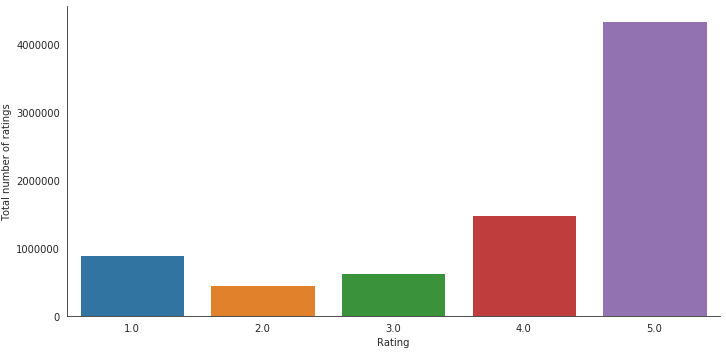

In [11]:
# Check the distribution of ratings 
with sns.axes_style('white'):
    g = sns.factorplot("Rating", data=df, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

##### Observation:
Most of the people have given rating of 5

In [12]:
# Number of unique user id and product id in the data
print('Number of unique USERS in Raw data = ', df['userId'].nunique())
print('Number of unique PRODUCTS in Raw data = ', df['productId'].nunique())


Number of unique USERS in Raw data =  4201696
Number of unique PRODUCTS in Raw data =  476002


## 2. Taking subset of the dataset to make it less sparse/ denser 
(keeping the users only who has given 50 or more number of ratings)

In [13]:
# Top 10 users based on rating
most_rated = df.groupby('userId').size().sort_values(ascending=False)[:10]
most_rated

userId
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
A1ODOGXEYECQQ8    380
A36K2N527TXXJN    314
A2AY4YUOX2N1BQ    311
AWPODHOB4GFWL     308
A25C2M3QF9G7OQ    296
dtype: int64

In [14]:
# Taking subset of the dataset - keeping the users only who has given 50 or more number of ratings
counts = df['userId'].value_counts()
df_final = df[df['userId'].isin(counts[counts >= 50].index)]

In [15]:
df_final.head()

,userId,productId,Rating
94,A3BY5KCNQZXV5U,0594451647,5.0
118,AT09WGFUM934H,0594481813,3.0
177,A32HSNCNPRUMTR,0970407998,1.0
178,A17HMM1M7T9PJ1,0970407998,4.0
492,A3CLWR1UUZT6TG,0972683275,5.0


In [16]:
df_final.shape

(125871, 3)

In [17]:
print('Number of users who have rated 50 or more items =', len(df_final))
print('Number of unique USERS in final data = ', df_final['userId'].nunique())
print('Number of unique PRODUCTS in final data = ', df_final['productId'].nunique())

Number of users who have rated 50 or more items = 125871
Number of unique USERS in final data =  1540
Number of unique PRODUCTS in final data =  48190


###### df_final has users who have rated 50 or more items

In [18]:
# Calculating the density of the rating matrix
final_ratings_matrix = pd.pivot_table(df_final,index=['userId'], columns = 'productId', values = "Rating")
final_ratings_matrix.fillna(0,inplace=True)
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

Shape of final_ratings_matrix:  (1540, 48190)
given_num_of_ratings =  125871
possible_num_of_ratings =  74212600
density: 0.17%


In [19]:
final_ratings_matrix.tail()

productId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
userId,,,,,,,,,,,,,,,,,,,,,
AZBXKUH4AIW3X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZCE11PSTCH1L,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZMY6E8B52L2T,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZNUHQSHZHSUE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZOK5STV85FBJ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
# Matrix with one row per 'product' and one column per 'user' for Item-based CF
final_ratings_matrix_T = final_ratings_matrix.transpose()
final_ratings_matrix_T.head()

userId,A100UD67AHFODS,A100WO06OQR8BQ,A105S56ODHGJEK,A105TOJ6LTVMBG,A10AFVU66A79Y1,A10H24TDLK2VDP,A10NMELR4KX0J6,A10O7THJ2O20AG,A10PEXB6XAQ5XF,A10X9ME6R66JDX,...,AYOTEJ617O60K,AYP0YPLSP9ISM,AZ515FFZ7I2P7,AZ8XSDMIX04VJ,AZAC8O310IK4E,AZBXKUH4AIW3X,AZCE11PSTCH1L,AZMY6E8B52L2T,AZNUHQSHZHSUE,AZOK5STV85FBJ
productId,,,,,,,,,,,,,,,,,,,,,
0594451647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0594481813,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0970407998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0972683275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1400501466,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 3. Spliting the data randomly into a train and test dataset (70/30 ratio)

In [21]:
#Split the training and test data in the ratio 70:30
train_data, test_data = train_test_split(df_final, test_size = 0.3, random_state=0)
print(train_data.head(5))

                 userId   productId  Rating
6595853  A2BYV7S1QP2YIG  B009EAHVTA     5.0
4738241   AB094YABX21WQ  B0056XCEAA     1.0
4175596  A3D0UM4ZD2CMAW  B004I763AW     5.0
3753016   AATWFX0ZZSE6C  B0040NPHMO     3.0
1734767  A1NNMOD9H36Q8E  B0015VW3BM     4.0


In [22]:
def shape():
    print("Train data shape: ", train_data.shape)
    print("Test data shape: ", test_data.shape)
shape()

Train data shape:  (88109, 3)
Test data shape:  (37762, 3)


## 4. Building Popularity Recommender Model

In [23]:
#Count of userId for each unique product as recommendation Rating 
train_data_grouped = train_data.groupby('productId').agg({'userId': 'count'}).reset_index()
train_data_grouped.rename(columns = {'userId': 'Rating'},inplace=True)
train_data_grouped.head()

,productId,Rating
0,0594451647,1
1,0594481813,1
2,0970407998,1
3,0972683275,3
4,1400501466,4


In [24]:
#Sorting the products on recommendation Rating 
train_data_sort = train_data_grouped.sort_values(['Rating', 'productId'], ascending = [0,1])

In [25]:
#Generating a recommendation rank based upon Rating 
train_data_sort['Rank'] = train_data_sort['Rating'].rank(ascending=0, method='first')

In [26]:
#Getting the top 5 recommendations 
popularity_recommendations = train_data_sort.head(5) 
popularity_recommendations

,productId,Rating,Rank
30847,B0088CJT4U,133,1.0
30287,B007WTAJTO,124,2.0
19647,B003ES5ZUU,122,3.0
8752,B000N99BBC,114,4.0
30555,B00829THK0,97,5.0


In [27]:
# Using popularity based recommendor model to make predictions
def recommend(user_id):     
    user_recommendations = popularity_recommendations 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['userId'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations

In [28]:
# Finding popularity based product recommendations based on list of 3 user ids (50,100 and 200) which are shared by users (this list is user's choice)
find_recom = [50,100,200]
for i in find_recom:
    print("Products recommendation for the userId based on popularity: %d\n" %(i))
    print(recommend(i))    
    print("\n")

Products recommendation for the userId based on popularity: 50

       userId   productId  Rating  Rank
30847      50  B0088CJT4U     133   1.0
30287      50  B007WTAJTO     124   2.0
19647      50  B003ES5ZUU     122   3.0
8752       50  B000N99BBC     114   4.0
30555      50  B00829THK0      97   5.0


Products recommendation for the userId based on popularity: 100

       userId   productId  Rating  Rank
30847     100  B0088CJT4U     133   1.0
30287     100  B007WTAJTO     124   2.0
19647     100  B003ES5ZUU     122   3.0
8752      100  B000N99BBC     114   4.0
30555     100  B00829THK0      97   5.0


Products recommendation for the userId based on popularity: 200

       userId   productId  Rating  Rank
30847     200  B0088CJT4U     133   1.0
30287     200  B007WTAJTO     124   2.0
19647     200  B003ES5ZUU     122   3.0
8752      200  B000N99BBC     114   4.0
30555     200  B00829THK0      97   5.0




##### Observation:
As this is the popularity-based recommendor model, product recommendations are same for all users. The products are recommended based on the popularity and not personalized to particular user.

###  5 a. Building Collaborative Filtering model using surprise package

In [29]:
# Using surprise package
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import train_test_split

In [30]:
# Taking smaller dataset to avoid memory error
df_new=df_final.iloc[:10000,0:]
df_new.shape

#Reading the dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_new,reader)


(10000, 3)

In [31]:
#Splitting the dataset
trainset, testset = train_test_split(data, test_size=0.3,random_state=10)

In [32]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
algo = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [33]:
# run the trained model against the testset
test_pred = algo.test(testset)

In [34]:
test_pred

[Prediction(uid='A5JLAU2ARJ0BO', iid='B00004T1KZ', r_ui=4.0, est=4.2868571428571425, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A3A15L96IYUO6V', iid='B00004SSRW', r_ui=5.0, est=4.2868571428571425, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A1435P5AMCPB3X', iid='B00009ZHVA', r_ui=5.0, est=4.2868571428571425, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='ACYZXQ2JKPZKT', iid='B00005LENO', r_ui=4.0, est=5, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='APQQK1V695AUE', iid='B00008W7LS', r_ui=5.0, est=4.2868571428571425, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A2NYK9KWFMJV4Y', iid='B00006JP23', r_ui=4.0, est=4.2868571428571425, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A27QXQQOLAMRRR', iid='B00009XVCZ', r_ui=5.0, est=4.82608

In [35]:
# Evaluating Collaborative Filtering model - Getting RMSE
print("Item-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

Item-based Model : Test Set
RMSE: 1.2116


1.2116388654398655

### 5 b. Building Model-based Collaborative Filtering using Singular Value Decomposition

In [36]:
df_CF = pd.concat([train_data, test_data]).reset_index()
df_CF.tail()

,index,userId,productId,Rating
125866,621872,A3OXHLG6DIBRW8,B0007UQNOA,3.0
125867,1942808,A365PBEOWM7EI7,B001DVZXC0,3.0
125868,5219963,A3QDY9I0CNMD2W,B005WXQO3W,5.0
125869,876608,AR18DH5SL9F73,B000EPR7AC,5.0
125870,975289,A3VL4RXCWNSR3H,B000GM7MRG,5.0


In [37]:
#User-based Collaborative Filtering
# Matrix with row per 'user' and column per 'item' 
pivot_df = pd.pivot_table(df_CF,index=['userId'], columns = 'productId', values = "Rating")
pivot_df.fillna(0,inplace=True)
print(pivot_df.shape)
pivot_df.head()

(1540, 48190)


productId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
userId,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.head()

productId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8,user_index
userId,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [39]:
pivot_df.set_index(['user_index'], inplace=True)

# Actual ratings given by users
pivot_df.head()

productId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### Since matrix is large & sparse, SVD method is applied

In [40]:
pivot_df.dtypes

productId
0594451647    float64
0594481813    float64
0970407998    float64
0972683275    float64
1400501466    float64
               ...   
B00LED02VY    float64
B00LGN7Y3G    float64
B00LGQ6HL8    float64
B00LI4ZZO8    float64
B00LKG1MC8    float64
Length: 48190, dtype: object

In [41]:
from scipy.sparse.linalg import svds
# SVD - Singular Value Decomposition
U, sigma, Vt = svds(pivot_df, k = 50)
# Construct diagonal array in SVD
sigma = np.diag(sigma)

In [42]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 

In [43]:
# Predicted ratings
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df.columns)
preds_df.head()

productId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.005086,0.002178,0.003668,-0.040843,0.009640,0.006808,0.020659,0.000649,0.020331,0.005633,...,0.000238,-0.061477,0.001214,-0.123433,0.028490,0.016109,0.002855,-0.174568,0.011367,-0.012997
1,0.002286,-0.010898,-0.000724,0.130259,0.007506,-0.003350,0.063711,-0.000674,0.016111,-0.002433,...,-0.000038,0.013766,0.001473,0.025588,-0.042103,0.004251,0.002177,-0.024362,-0.014765,0.038570
2,-0.001655,-0.002675,-0.007355,0.007264,0.005152,-0.003986,-0.003480,0.006961,-0.006606,-0.002719,...,-0.001708,-0.051040,0.000325,-0.054867,0.017870,-0.004996,-0.002426,0.083928,-0.112205,0.005964
3,0.001856,0.011019,-0.005910,-0.014134,0.000179,0.001877,-0.005391,-0.001709,0.004968,0.001402,...,0.000582,-0.009326,-0.000465,-0.048315,0.023302,0.006790,0.003380,0.005460,-0.015263,-0.025996
4,0.001115,-0.002670,0.011018,0.014434,0.010319,0.006002,0.017151,0.003726,0.001404,0.005645,...,0.000207,0.023761,0.000747,-0.019347,-0.012749,0.001026,0.001364,-0.020580,0.011828,0.012770


## 6. Evaluation of Model-based Collaborative Filtering (SVD)

In [44]:
# Actual ratings given by the users
final_ratings_matrix.head()

productId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
userId,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
# Average ACTUAL rating for each item
final_ratings_matrix.mean().head()

productId
0594451647    0.003247
0594481813    0.001948
0970407998    0.003247
0972683275    0.012338
1400501466    0.012987
dtype: float64

In [46]:
# Predicted ratings 
preds_df.head()

productId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.005086,0.002178,0.003668,-0.040843,0.009640,0.006808,0.020659,0.000649,0.020331,0.005633,...,0.000238,-0.061477,0.001214,-0.123433,0.028490,0.016109,0.002855,-0.174568,0.011367,-0.012997
1,0.002286,-0.010898,-0.000724,0.130259,0.007506,-0.003350,0.063711,-0.000674,0.016111,-0.002433,...,-0.000038,0.013766,0.001473,0.025588,-0.042103,0.004251,0.002177,-0.024362,-0.014765,0.038570
2,-0.001655,-0.002675,-0.007355,0.007264,0.005152,-0.003986,-0.003480,0.006961,-0.006606,-0.002719,...,-0.001708,-0.051040,0.000325,-0.054867,0.017870,-0.004996,-0.002426,0.083928,-0.112205,0.005964
3,0.001856,0.011019,-0.005910,-0.014134,0.000179,0.001877,-0.005391,-0.001709,0.004968,0.001402,...,0.000582,-0.009326,-0.000465,-0.048315,0.023302,0.006790,0.003380,0.005460,-0.015263,-0.025996
4,0.001115,-0.002670,0.011018,0.014434,0.010319,0.006002,0.017151,0.003726,0.001404,0.005645,...,0.000207,0.023761,0.000747,-0.019347,-0.012749,0.001026,0.001364,-0.020580,0.011828,0.012770


In [47]:
# Average PREDICTED rating for each item
preds_df.mean().head()

productId
0594451647    0.001953
0594481813    0.002875
0970407998    0.003355
0972683275    0.010343
1400501466    0.004871
dtype: float64

In [48]:
rmse_df = pd.concat([final_ratings_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(48190, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
productId,,,
0594451647,0.003247,0.001953,0
0594481813,0.001948,0.002875,1
0970407998,0.003247,0.003355,2
0972683275,0.012338,0.010343,3
1400501466,0.012987,0.004871,4


In [49]:
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.00275 



## 7. Getting top - K ( K = 5) recommendations. Goal is to recommend new products to each user based on his/her habits : 5 new products are recommended

In [50]:
# Recommend the items with the highest predicted ratings

def recommend_items(userID, pivot_df, preds_df, num_recommendations):
      
    user_idx = userID-1 # index starts at 0
    
    # Get and sort the user's ratings
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_predictions

    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

In [51]:
# Enter 'userID' and 'num_recommendations' for the user #
userID = 100
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 100):

                   user_ratings  user_predictions
Recommended Items                                
B000QUUFRW                  0.0          0.707524
B002V88HFE                  0.0          0.646016
B007WTAJTO                  0.0          0.580565
B002WE6D44                  0.0          0.487400
B000AZ57M6                  0.0          0.484131


## 8. Summary of Insights

1. Model-based Collaborative Filtering is a personalised recommender system, the recommendations are based on the past behavior of the user and it is not dependent on any additional information.

2. The number of products are quite large, so user has various options, however there are ceratin products which are sold quite often and can be easily recommended to a new user as they are best selling product.

3. The Popularity-based recommender system is non-personalised and the recommendations are based on frequency counts, which may be not suitable to the user. 

The difference can be noted above for the user id = 100, The Popularity based model has recommended the <b> same </b> set of 5 products for different users. However, Collaborative Filtering based model has recommended entire different list based on the user's past purchase history